## Import Environment 

In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import random
import argparse
import random
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
          
#openCV
import cv2                          

In [2]:
#Tensor Flow
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import vgg16

from tensorflow.keras import callbacks
from tensorflow.keras.applications import xception
from tensorflow.keras.models import Model

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D,Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [3]:
import subprocess

def get_gpu_details():
    try:
        result = subprocess.run(['nvidia-smi'], capture_output=True)
        output = result.stdout.decode('utf-8')
        print(output)
    except FileNotFoundError:
        print("nvidia-smi not found. Please make sure NVIDIA drivers are installed.")

# Call the function to display GPU details
get_gpu_details()

Sun May 19 20:30:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P0              17W /  30W |    224MiB /  4096MiB |     37%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
df_final = pd.read_csv("./data/df_clean_Task3_2.csv")

In [8]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81335 entries, 0 to 81334
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImgPath  81335 non-null  object
 1   Class    81335 non-null  object
 2   Style    81335 non-null  object
dtypes: object(3)
memory usage: 1.9+ MB


### Image Preprocessing

In [9]:
import os
import cv2
import tensorflow as tf
import pandas as pd  # Assuming pandas is imported to work with DataFrame

# Initialize counters for each style
style_counts = {}

# Function to check if the limit is reached for a style
def is_limit_reached(style):
    return style_counts.get(style, 0) >= 500

tags = []
images = []
path = []

with tf.device('GPU:0'):
    # Iterate over each row in the DataFrame
    for index, row in df_final.iterrows():
        img_path = row['ImgPath']
        category = row['Class']
        style = row['Style']
        
        # Check if the style limit has been reached
        if is_limit_reached(style):
            continue
        
        # Extract the image name from the path
        image_name = os.path.basename(img_path)
        
        # Extract the parent folder name (e.g., "Asian")
        parent_folder_name = os.path.basename(os.path.dirname(img_path))

        if os.path.exists(img_path):
            img_arr = cv2.imread(img_path)
            if img_arr is not None:
                img_arr = cv2.resize(img_arr, (150, 150))
                path.append(img_path)
                images.append(img_arr)
                tags.append([category.lower(), style.lower()])
                
                # Increment the style counter
                style_counts[style] = style_counts.get(style, 0) + 1
            
            else:
                print(f"Warning: Unable to read image at path {img_path}")
        else:
            print(f"Warning: Path does not exist: {img_path}")

# Verify the results
print(f"Total images loaded: {len(images)}")
print(f"Total tags collected: {len(tags)}")
print(f"Total paths collected: {len(path)}")

# Optional: print counts for each style
print("Counts per style:")
for style, count in style_counts.items():
    print(f"{style}: {count}")

Total images loaded: 8249
Total tags collected: 8249
Total paths collected: 8249
Counts per style:
Asian: 500
Beach: 500
Contemporary: 500
Craftsman: 500
Eclectic: 500
Farmhouse: 500
Industrial: 500
Mediterranean: 500
Midcentury: 500
Modern: 500
Rustic: 500
Scandinavian: 401
Southwestern: 348
Traditional: 500
Transitional: 500
Tropical: 500
Victorian: 500


In [10]:
images,tags = shuffle(images,tags,random_state=42)

### Transform tags to binary values

In [11]:
mlb = MultiLabelBinarizer()
tags = mlb.fit_transform(tags)

In [12]:
# Save the images to a .npy file
images_array = np.array(images)
np.save('images.npy', images_array)

# Save the tags to a CSV file
tags_df = pd.DataFrame(tags, columns=mlb.classes_)
tags_df.to_csv('tags.csv', index=False)

print("Images and tags saved successfully.")

Images and tags saved successfully.


In [13]:
pd.DataFrame(list(mlb.classes_)).to_csv('classes.csv',index=False)

In [17]:
# Load the images
images = np.load('images.npy')

# Load the tags
tags_df = pd.read_csv('tags.csv')

# Display loaded data shapes
print("Images shape:", images.shape)
print("Tags DataFrame shape:", tags_df.shape)

# Convert tags DataFrame back to numpy array
tags = tags_df.values

# Verify loaded data
print("Tags shape:", tags.shape)

Images shape: (8249, 150, 150, 3)
Tags DataFrame shape: (8249, 23)
Tags shape: (8249, 23)


In [18]:
fullsize = len(images)
trainsize = int(fullsize*0.7)
testsize = int(trainsize+fullsize*0.15)

### Split Data 

In [19]:
X_train=np.array(images[0:trainsize])
y_train=np.array(tags[0:trainsize])
X_test=np.array(images[trainsize:testsize])
y_test=np.array(tags[trainsize:testsize])
X_val=np.array(images[testsize:])
y_val=np.array(tags[testsize:])

### Parameter

In [20]:
epo = 30
init_lr = 1e-3
bs = 32
image_dims = (150, 150, 3)

### ImageDataGenerator

In [21]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")


test_datagen = ImageDataGenerator(
    rescale=1./255)


train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32)

#### Model 1: VGG16 with all layers freezed, one 256 nodes fully-connected layer

In [19]:
from tensorflow.keras.models import Model

base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(256,activation='relu')(x)
predictions = Dense(23, activation='sigmoid')(x)

model0 = Model(inputs=base_model.input, outputs=predictions)

print (model0.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [20]:
opt = Adam(lr=init_lr)
model0.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])    

cp_callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
               tf.keras.callbacks.ModelCheckpoint(filepath='model0.{epoch:02d}-{val_loss:.2f}.h5',verbose=1),
               tf.keras.callbacks.TensorBoard(log_dir='./logs'),]

# Train the model with the new callback

hist0 = model0.fit(train_generator,steps_per_epoch=len(X_train)/bs,
                 epochs=epo,
                 validation_data=test_generator,
                 callbacks=cp_callback,verbose=1)  # Pass callback to training

D:\Anaconda\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/30
181/180 [==============================] - ETA: 0s - loss: 0.1898 - accuracy: 0.6896
Epoch 1: saving model to model0.01-0.15.h5
180/180 [==============================] - 40s 172ms/step - loss: 0.1898 - accuracy: 0.6896 - val_loss: 0.1515 - val_accuracy: 0.7478
Epoch 2/30
181/180 [==============================] - ETA: 0s - loss: 0.1537 - accuracy: 0.7265
Epoch 2: saving model to model0.02-0.14.h5
180/180 [==============================] - 28s 157ms/step - loss: 0.1537 - accuracy: 0.7265 - val_loss: 0.1382 - val_accuracy: 0.7639
Epoch 3/30
181/180 [==============================] - ETA: 0s - loss: 0.1442 - accuracy: 0.7336
Epoch 3: saving model to model0.03-0.13.h5
180/180 [==============================] - 29s 158ms/step - loss: 0.1442 - accuracy: 0.7336 - val_loss: 0.1310 - val_accuracy: 0.7712
Epoch 4/30
181/180 [==============================] - ETA: 0s - loss: 0.1372 - accuracy: 0.7397
Epoch 4: saving model to model0.04-0.13.h5
180/180 [==============================] -

In [21]:
import pickle
model0.save("multilabel0")

with open('trainhist0', 'wb') as file_pi:
      pickle.dump(hist0.history, file_pi)

INFO:tensorflow:Assets written to: multilabel0\assets


INFO:tensorflow:Assets written to: multilabel0\assets


In [22]:
with open('trainhist0', 'rb') as file_pi:
    # Load the pickled data into a variable
    hist0 = pickle.load(file_pi)

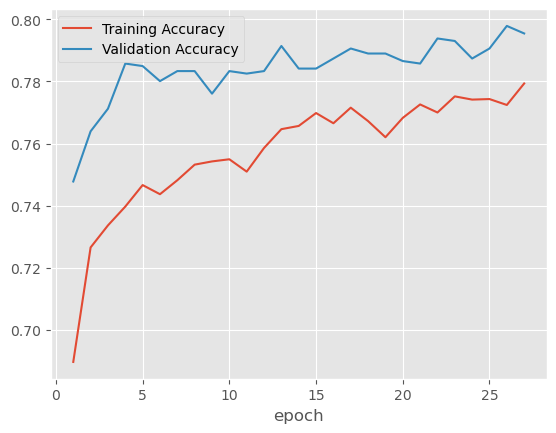

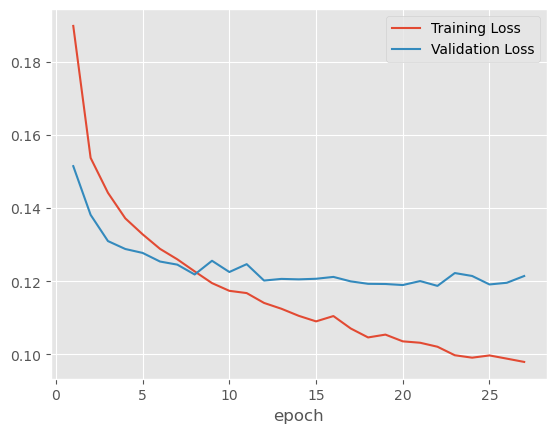

In [24]:
# Plot accuracy
epoch_list = list(range(1, len(hist0['accuracy']) + 1))  # values for x axis [1, 2, ..., # of epochs]
plt.plot(epoch_list, hist0['accuracy'], epoch_list, hist0['val_accuracy'])
plt.legend(('Training Accuracy', 'Validation Accuracy'))
plt.xlabel('epoch')
plt.show()

# Plot loss
epoch_list = list(range(1, len(hist0['loss']) + 1))  # values for x axis [1, 2, ..., # of epochs]
plt.plot(epoch_list, hist0['loss'], epoch_list, hist0['val_loss'])
plt.legend(('Training Loss', 'Validation Loss'))
plt.xlabel('epoch')
plt.show()

### Model 2: VGG with last 1 blocks trainable and one 256 nodes and 128 nodes fully-connected layer

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D, BatchNormalization
base_model1 = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    
for layer in base_model1.layers[:15]: 
    layer.trainable = False 

for layer in base_model1.layers[15:]: 
    layer.trainable = True

# Build the new top layers
# Add regularization and batch normalization
x = base_model1.output
x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128,activation='relu')(x)
predictions = Dense(23, activation='sigmoid')(x)

# Output layer with sigmoid activation for multi-label classification
predictions = Dense(23, activation='sigmoid')(x)
model1 = Model(inputs=base_model1.input, outputs=predictions)

print (model1.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Data augmentation

opt = Adam(lr=init_lr)
model1.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])    

In [27]:
# Callbacks
cb = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
]


# Train the model with the new callback
with tf.device('GPU:0'):
    hist1 = model1.fit(train_generator,steps_per_epoch=len(X_train)/bs,
                     epochs=epo,
                     validation_data=test_generator,
                    callbacks= cb,
                     verbose=1)  # Pass callback to training

Epoch 1/30
181/180 [==============================] - ETA: 0s - loss: 0.2673 - accuracy: 0.4806
Epoch 1: val_loss improved from inf to 0.18477, saving model to best_model.h5
180/180 [==============================] - 30s 160ms/step - loss: 0.2673 - accuracy: 0.4806 - val_loss: 0.1848 - val_accuracy: 0.7502 - lr: 0.0010
Epoch 2/30
181/180 [==============================] - ETA: 0s - loss: 0.1941 - accuracy: 0.7248
Epoch 2: val_loss improved from 0.18477 to 0.16158, saving model to best_model.h5
180/180 [==============================] - 28s 156ms/step - loss: 0.1941 - accuracy: 0.7248 - val_loss: 0.1616 - val_accuracy: 0.7753 - lr: 0.0010
Epoch 3/30
181/180 [==============================] - ETA: 0s - loss: 0.1775 - accuracy: 0.7445
Epoch 3: val_loss improved from 0.16158 to 0.15724, saving model to best_model.h5
180/180 [==============================] - 29s 158ms/step - loss: 0.1775 - accuracy: 0.7445 - val_loss: 0.1572 - val_accuracy: 0.7728 - lr: 0.0010
Epoch 4/30
181/180 [=========

In [28]:
import pickle
model1.save("multilabel1")
with open('trainhist1', 'wb') as file_pi:
      pickle.dump(hist1.history, file_pi)

INFO:tensorflow:Assets written to: multilabel1\assets


INFO:tensorflow:Assets written to: multilabel1\assets


In [29]:
model1.save('model1_Task3.h5')

### Loading Model and Predict

In [30]:
from tensorflow.keras.models import load_model
model = load_model('model1_Task3.h5')

In [31]:
with open('trainhist1', 'rb') as file_pi:
    # Load the pickled data into a variable
    hist1 = pickle.load(file_pi)

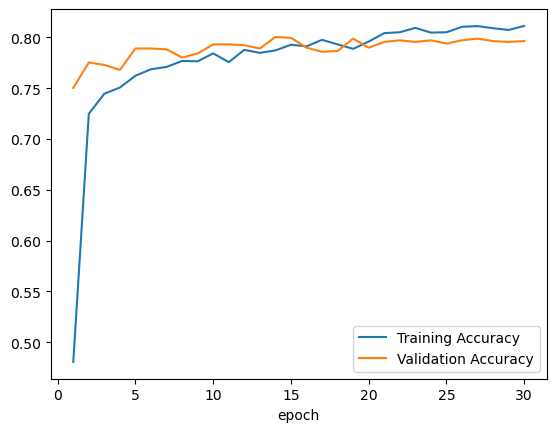

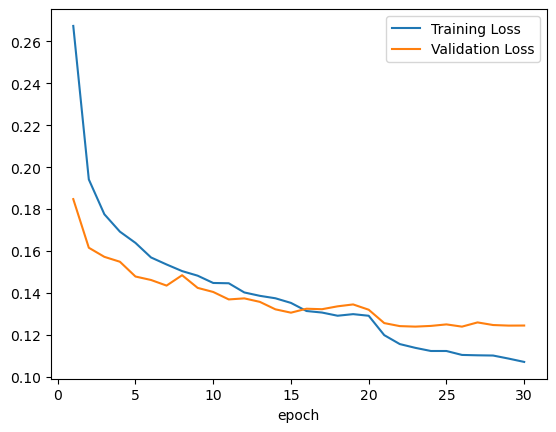

In [32]:
# Plot accuracy
epoch_list = list(range(1, len(hist1['accuracy']) + 1))  # values for x axis [1, 2, ..., # of epochs]
plt.plot(epoch_list, hist1['accuracy'], epoch_list, hist1['val_accuracy'])
plt.legend(('Training Accuracy', 'Validation Accuracy'))
plt.xlabel('epoch')
plt.show()

# Plot loss
epoch_list = list(range(1, len(hist1['loss']) + 1))  # values for x axis [1, 2, ..., # of epochs]
plt.plot(epoch_list, hist1['loss'], epoch_list, hist1['val_loss'])
plt.legend(('Training Loss', 'Validation Loss'))
plt.xlabel('epoch')
plt.show()

In [6]:
# Load and preprocess the image
def load_and_preprocess_image(img_path, target_size):
    # Load the image with the target size
    img = image.load_img(img_path, target_size=target_size)
    # Convert the image to a numpy array
    img_array = image.img_to_array(img)
    # Expand dimensions to match the shape that the model expects (1, height, width, channels)
    img_array = np.expand_dims(img_array, axis=0)
    # Normalize the image array (optional, depends on your model's training)
    img_array /= 255.0
    return img_array

In [34]:
# Path to the new query image
img_path = './query_image/5924southwestern-dressers.jpg'

# Assuming the model expects 224x224 images, adjust if different
target_size = (150, 150)

# Preprocess the image
preprocessed_image = load_and_preprocess_image(img_path, target_size)

# Make the prediction
predictions = model.predict(preprocessed_image)


1/1 [==============================] - 0s 135ms/step


In [35]:
# Define the label mapping
labels = [
    "asian", "beach", "beds", "chairs", "contemporary", "craftsman", "dressers",
    "eclectic", "farmhouse", "industrial", "lamps", "mediterranean", "midcentury",
    "modern", "rustic", "scandinavian", "sofas", "southwestern", "tables",
    "traditional", "transitional", "tropical", "victorian"
]

In [36]:
print(predictions)

[[1.75138880e-02 4.86499257e-03 3.41406121e-06 4.38827556e-06
  6.12234763e-10 8.01720992e-02 9.99997735e-01 7.77144858e-04
  1.76609080e-06 1.27603828e-09 6.35552681e-07 1.89760476e-02
  1.25204269e-09 1.03691189e-08 2.51157453e-05 1.79136202e-06
  5.81936721e-09 8.75562012e-01 1.41743999e-06 1.03879486e-07
  9.00866155e-08 2.03113593e-02 4.65210006e-02]]


In [37]:
# Define category and style groups
category_labels = ["beds", "chairs", "dressers", "lamps", "sofas", "tables"]
style_labels = [label for label in labels if label not in category_labels]

# Initialize max probabilities and labels
max_category_prob = -1
max_category_label = None
max_style_prob = -1
max_style_label = None

# Iterate over the predictions and labels
for prob, label in zip(predictions[0], labels):
    if label in category_labels:
        if prob > max_category_prob:
            max_category_prob = prob
            max_category_label = label
    else:
        if prob > max_style_prob:
            max_style_prob = prob
            max_style_label = label

# Print the results
print(f"Category: {max_category_label}")
print(f"Style: {max_style_label}")

Category: dressers
Style: southwestern


### Similarity Recommendations

In [4]:
# Load model
from tensorflow.keras.models import load_model
model = load_model('model1_Task3.h5') 

In [7]:
# Path to the new query image
query_image_path = './query_image/5924southwestern-dressers.jpg'

# Assuming the model expects 224x224 images, adjust if different
target_size = (150, 150)

# Preprocess the image
preprocessed_image = load_and_preprocess_image(query_image_path, target_size)

# Make the prediction
predictions = model.predict(preprocessed_image)

1/1 [==============================] - 6s 6s/step


In [8]:
# Define the label mapping
labels = [
    "asian", "beach", "beds", "chairs", "contemporary", "craftsman", "dressers",
    "eclectic", "farmhouse", "industrial", "lamps", "mediterranean", "midcentury",
    "modern", "rustic", "scandinavian", "sofas", "southwestern", "tables",
    "traditional", "transitional", "tropical", "victorian"
]

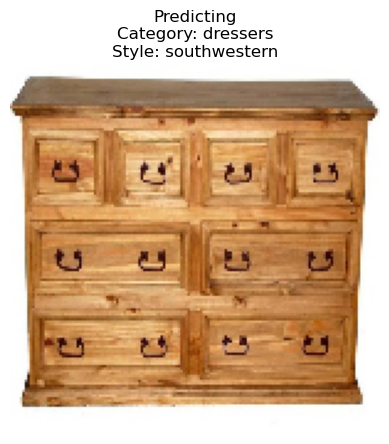

Category: dressers
Style: southwestern


In [9]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define category and style groups
category_labels = ["beds", "chairs", "dressers", "lamps", "sofas", "tables"]
style_labels = [label for label in labels if label not in category_labels]

# Initialize max probabilities and labels
max_category_prob = -1
max_category_label = None
max_style_prob = -1
max_style_label = None

# Iterate over the predictions and labels
for prob, label in zip(predictions[0], labels):
    if label in category_labels:
        if prob > max_category_prob:
            max_category_prob = prob
            max_category_label = label
    else:
        if prob > max_style_prob:
            max_style_prob = prob
            max_style_label = label

query_image = load_img(query_image_path, target_size=target_size)  # Load and resize the image
# Display the image and the prediction
plt.imshow(query_image)
plt.title(f"Predicting\nCategory: {max_category_label}\nStyle: {max_style_label}")
plt.axis('off')  # Turn off axis labels
plt.show()

# Print the results
print(f"Category: {max_category_label}")
print(f"Style: {max_style_label}")

In [10]:
from joblib import dump, load
df = pd.read_csv('./data/df_clean_Task3_2.csv')
# Load compressed data
histogram_values = load('./data/histogram_values1_compressed.joblib')
texture_values = load('./data/texture_values1_compressed.joblib')
compactness_values = load('./data/compactness1_values_compressed.joblib')

In [11]:
matching_histograms = []
matching_textures = []
matching_compactness = []
matching_image_files = []

#### Extract images with matching predicted label

In [12]:
df = pd.read_csv('./data/df_clean_Task3_2.csv')
for index, row in df.iterrows():
    image_path = row['ImgPath']
    category = row['Class']
    style = row['Style']
    if category.casefold() == max_category_label.casefold() and style.casefold() == max_style_label.casefold():
        matching_histograms.append(histogram_values[index])
        matching_textures.append(texture_values[index])
        matching_compactness.append(compactness_values[index])
        matching_image_files.append(image_path)


## Extract features values of query image

In [13]:
import cv2
import numpy as np
import os
import mahotas.features.texture as texture
from tkinter import Tk
from tkinter.filedialog import askopenfilename
# Prompt the user to browse and select the query image
bins = 32
# Tk().withdraw()  # Hide the main window
# query_image_path = askopenfilename( title="Select the input Image")

# Read the query image
query_image = cv2.imread(query_image_path)

# Calculate the color histogram for the query image
query_histogram = cv2.calcHist([query_image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
query_histogram = cv2.normalize(query_histogram, query_histogram).flatten()

# Calculate the texture features for the query image
query_gray_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2GRAY)
query_glcm = texture.haralick(query_gray_image)
query_texture_features = np.mean(query_glcm, axis=0)

# Threshold the query image to obtain a binary image
# _, query_thresholded = cv2.threshold(query_gray_image, 127, 255, cv2.THRESH_BINARY)
_, query_thresholded = cv2.threshold(query_gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Find contours in the binary image
query_contours, _ = cv2.findContours(query_thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if query_contours:
    query_contour = max(query_contours, key=cv2.contourArea)
    query_area = cv2.contourArea(query_contour)
    query_perimeter = cv2.arcLength(query_contour, True)
    query_compactness = query_perimeter / np.sqrt(query_area) if query_area > 0 else 0
else:
    query_compactness = 0  # Handle no contours found

# # Calculate the contour area and perimeter for the query image
# query_contour = query_contours[0]
# query_area = cv2.contourArea(query_contour)
# query_perimeter = cv2.arcLength(query_contour, True)

# Calculate the compactness as the ratio of perimeter to the square root of area for the query image
# query_compactness = query_perimeter / np.sqrt(query_area)

In [14]:
import numpy as np

def calculate_weighted_distance(color_distance, texture_distance, shape_distance):
    # Constants to control the emphasis of each feature
    alpha = 1    # Weight for color distance
    beta = 100   # Weight for texture distance
    gamma = 40   # Weight for shape distance

    # Applying logarithmic scaling to distances
    # Adding 1 inside the log function to avoid log(0) which is undefined
    log_color_distance = np.log1p(color_distance)
    log_texture_distance = np.log1p(texture_distance)
    log_shape_distance = np.log1p(shape_distance)

    # Calculate weighted sum of logarithmic distances
    weighted_distance = alpha * log_color_distance + beta * log_texture_distance + gamma * log_shape_distance
    return weighted_distance, log_color_distance, log_texture_distance, log_shape_distance

#### Compare the difference between query images and other images in terms of histogram, shape and texture, then sort in ascending order

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Define the number of similar images to retrieve
k = 10

# Perform nearest neighbor search based on feature vectors
similar_images = []
for index in range(len(matching_image_files)):
    image_file = matching_image_files[index]
    histogram = matching_histograms[index]
    texture_features = matching_textures[index]
    compactness = matching_compactness[index]
    
    # Calculate the distance between the query image features and the current image features
    color_distance = cv2.compareHist(query_histogram, histogram, cv2.HISTCMP_CHISQR)
    texture_distance = np.linalg.norm(query_texture_features - texture_features)
    shape_distance = np.abs(query_compactness - compactness)
    
    weighted_distance, raw_color_distance, raw_texture_distance, raw_shape_distance = calculate_weighted_distance(
        color_distance, texture_distance, shape_distance)
    
    similar_images.append((image_file, weighted_distance, raw_color_distance, raw_texture_distance, raw_shape_distance))

# Sort the similar images based on distance
similar_images.sort(key=lambda x: x[1])

## Recommend the top 10 similar with query image

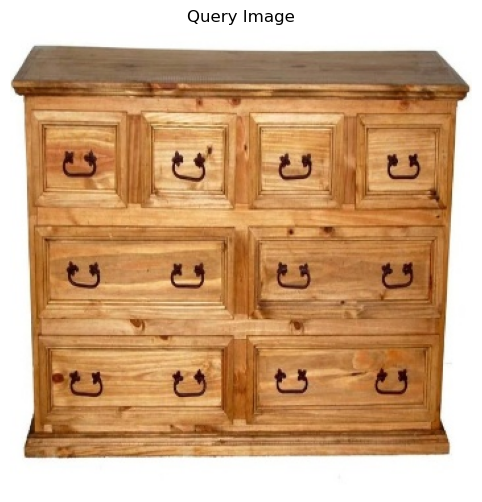

Similar images:
Image: data/Furniture_Data\dressers\Southwestern\5924southwestern-dressers.jpg
Image: data/Furniture_Data\dressers\Southwestern\5926southwestern-dressers.jpg
Image: data/Furniture_Data\dressers\Southwestern\6097southwestern-dressers.jpg
Image: data/Furniture_Data\dressers\Southwestern\6118southwestern-dressers.jpg
Image: data/Furniture_Data\dressers\Southwestern\5962southwestern-dressers.jpg
Image: data/Furniture_Data\dressers\Southwestern\5993southwestern-dressers.jpg
Image: data/Furniture_Data\dressers\Southwestern\2590southwestern-dressers.jpg
Image: data/Furniture_Data\dressers\Southwestern\6066southwestern-dressers.jpg
Image: data/Furniture_Data\dressers\Southwestern\5943southwestern-dressers.jpg
Image: data/Furniture_Data\dressers\Southwestern\5978southwestern-dressers.jpg


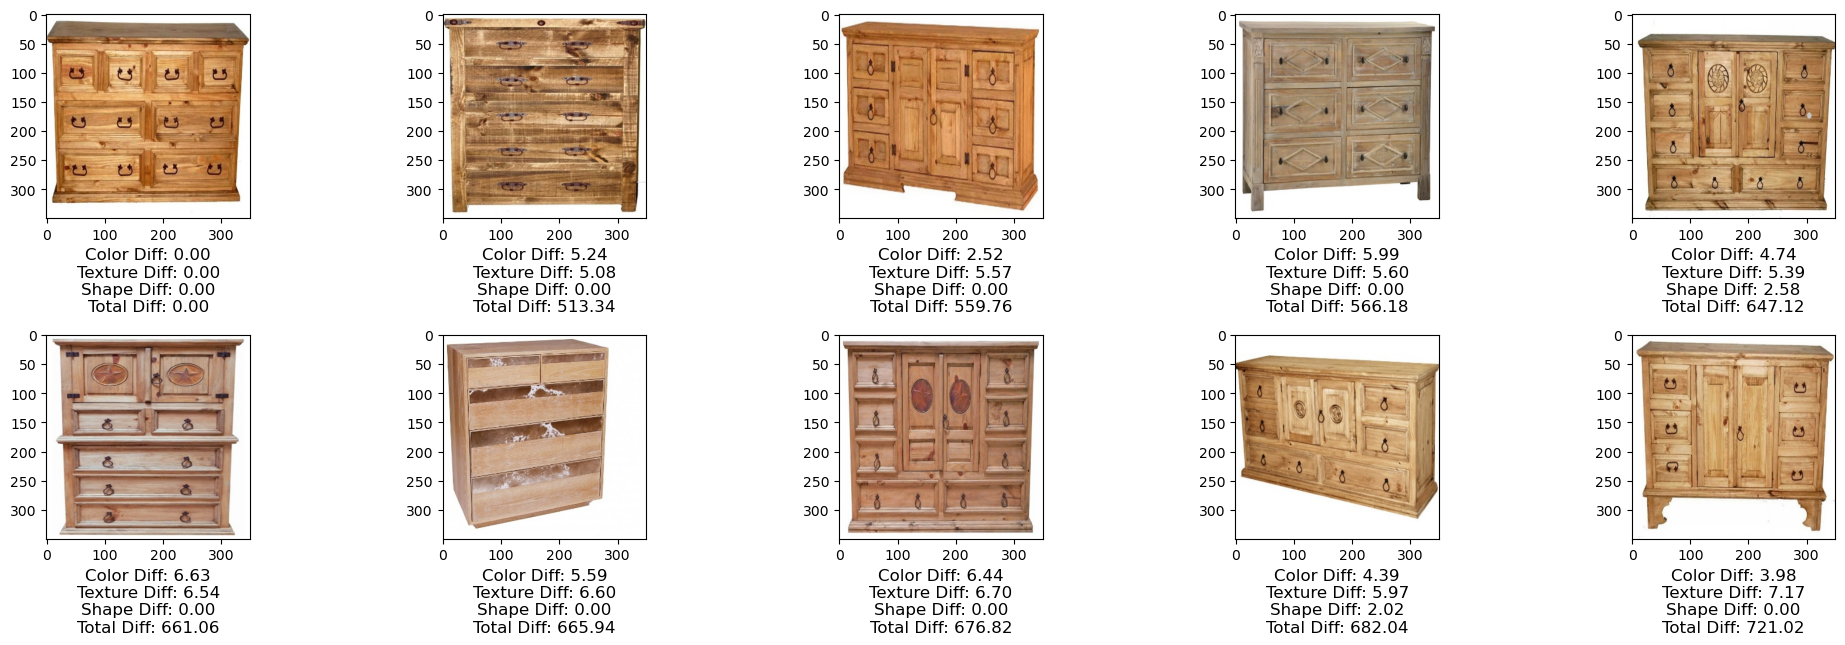

In [16]:
# Display the query image (using the uploaded image for demonstration)
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB))
plt.title("Query Image")
plt.axis('off')
plt.show()

# Display the top k similar images
print(f"Similar images:")

plt.figure(figsize=(20, 12))
plt.rc('axes', labelsize=15)

for i in range(k):
    image_file, distance, color_dist, texture_dist, shape_dist = similar_images[i]
    print(f"Image: {image_file}")
    plt.subplot(4, 5, i + 1)
    similar_image = cv2.imread(image_file)
    similar_image_rgb = cv2.cvtColor(similar_image, cv2.COLOR_BGR2RGB)
    plt.imshow(similar_image_rgb)
    
    plt.xlabel(f"Color Diff: {color_dist:.2f}\nTexture Diff: {texture_dist:.2f}\nShape Diff: {shape_dist:.2f}\nTotal Diff: {distance:.2f}", fontsize=12)
    # plt.axis('off')

plt.tight_layout()
plt.show()
